# Quick start
The INCA parser introduce a python wrapper to the Matlab application INCA. INCA can apply multiple 13C-MFA great algorithms. Unfortunately, it is meant to be used through a GUI and therefore it is laborious to handle many samples and measurements and is hard in incorporate into high throughput pipelines. The INCA parser operates on both sides of INCA it helps input model and data into INCA, it can run INCA algorithms and finally provides a workflow to export the results from INCA after execution of algorithms. This will be a very quick walk through of how to use the INCA Parser to give interested users an overview of the capabilities.

In [13]:
import pandas as pd
import pathlib
import incawrapper
from incawrapper import run_inca
import ast


The input data to the INCA parser is given as pandas dataframes. These has to comply to specified dataschemas (See :ref:`input_data.ipynb` for a thorough walk through of the requirements). The minimum inputs to run MFA in INCA is 

- Reaction data
- Tracer data

For stationary 13C-MFA least one of

- Flux measurements
- MS measurements

For Isotopically Non-stationary 13C-MFA additionally measurements of the metabolite pool are can be used.

Let's load some data to see the format of the input. All input data is validated for column name and data types, thus it will raise an error if either of those are incorrect.

In [14]:
data_folder = pathlib.Path("./examples/Literature data/simple model")
tracers_data = pd.read_csv(data_folder / "tracers.csv", 
   converters={'atom_mdv':ast.literal_eval, 'atom_ids':ast.literal_eval} # a trick to read lists from csv
)
reactions_data = pd.read_csv(data_folder / "reactions.csv")
flux_data = pd.read_csv(data_folder / "flux_measurements.csv")
ms_data = pd.read_csv(data_folder / "ms_measurements.csv", 
   converters={'labelled_atom_ids': ast.literal_eval} # a trick to read lists from csv
)

We use a simple toy model with 5 reactions [1,2]. In this data set we have two experiments exp1 and exp2. They were conducted with different tracers. For exp1 we have both flux and MS measurements, while for exp2 the data set only contains MS measurements. 

In [15]:
reactions_data.head()

,model,rxn_id,rxn_eqn
0,simple_model,R1,A (abc) -> B (abc)
1,simple_model,R2,B (abc) <-> D (abc)
2,simple_model,R3,B (abc) -> C (bc) + E (a)
3,simple_model,R4,B (abc) + C (de) -> D (bcd) + E (a) + E (e)
4,simple_model,R5,D (abc) -> F (abc)


In [16]:
tracers_data.head()

,experiment_id,met_id,tracer_id,atom_ids,ratio,atom_mdv,enrichment
0,exp1,A,[2-13C]A,[2],1.0,"[0, 1]",1
1,exp2,A,"[1,2-13C]A","[1, 2]",0.5,"[0.05, 0.95]",1


In [17]:
flux_data.head()

,experiment_id,rxn_id,flux,flux_std_error
0,exp1,R1,10.0,0.00001


In [18]:
ms_data.head()

,experiment_id,met_id,ms_id,measurement_replicate,labelled_atom_ids,unlabelled_atoms,mass_isotope,intensity,intensity_std_error,time
0,exp1,F,F1,1,"[1, 2, 3]",NaN,0,0.0001,0.000002,0
1,exp1,F,F1,1,"[1, 2, 3]",NaN,1,0.8008,0.016016,0
2,exp1,F,F1,1,"[1, 2, 3]",NaN,2,0.1983,0.003966,0
3,exp1,F,F1,1,"[1, 2, 3]",NaN,3,0.0009,0.000018,0
4,exp2,F,F1,1,"[1, 2, 3]",NaN,0,0.0002,0.000002,0


With the data loaded we are ready to create the INCA script that specifies the model, data and algorithms that we wish to apply. We will specify that the estimation algorithm should do 5 restarts and that INCA should not do naturel abundance correction. Finally, specify that we wish to run three of INCA's algorithms: estimate, simulate and continuate and that the model including the results should be saved in a file called simple_model_quickstart.mat in the current working directory.

In [19]:
output_file = pathlib.Path("./examples/Literature data/simple model/simple_model_quikstart.mat")
script = incawrapper.create_inca_script_from_data(reactions_data, tracers_data, flux_data, ms_data, experiment_ids=["exp1"])
script.add_to_block("options", incawrapper.define_options(fit_starts=5,sim_na=False))
script.add_to_block("runner", incawrapper.define_runner(output_file, run_estimate=True, run_simulation=True, run_continuation=True))

Now the script is ready to run in matlab.

In [20]:
import dotenv
inca_directory = pathlib.Path(dotenv.get_key(dotenv.find_dotenv(), "INCA_base_directory"))
incawrapper.run_inca(script, INCA_base_directory=inca_directory)

INCA script saved to /var/folders/z6/mxpxh4k56tv0h0ff41vmx7gdwtlpvp/T/tmpkga0p7fp/inca_script.m.
Starting MATLAB engine...
 
ms_exp1 = 1x1 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
F1
 
 
m = 1x1 model object
 
fields: [expts]  [mets]  notes  [options]  [rates]  [states]  
 
	5 reactions (6 fluxes)                                  
	6 states (3 balanced, 1 source, 2 sink and 0 unbalanced)
	6 metabolites                                           
	1 experiments                                           
 

                                         Directional 
 Iteration      Residual     Step-size    derivative        Lambda
     0       9.99596e+11
     1       8.14509e+11        0.0973     -9.02e+11       1.51438
     2           1471.59             1          -311       1.51438
     3           1686.79             1      2.43e+03      0.504795
     4           1647.49             1      2.35e+03       1.00959
     5           1451.25             1      1.97e+03  

We can now read the results from INCA using the `INCAResults` object.

In [21]:
res = incawrapper.INCAResults(output_file)

Typically, the first thing we want to inspect is the fitted fluxes. They can be displayed as a Pandas dataframe.

In [22]:
res.fitdata.fitted_parameters

,type,id,eqn,val,std,lb,ub,unit,free,alf,chi2s,cont,cor,cov,vals,base
0,Net flux,R1,A -> B,10.000000,0.000010,9.99998,10.00002,[],0,0.05,"[141.10066093755805, 140.33236917370687, 139.5...",0,"[1.0, 8.94704371251548e-05, 2.002130779029279e...","[9.999999786569624e-11, 6.084217157864558e-11,...","[9.999978529670276, 9.999980400360155, 9.99998...",{'id': []}
1,Net flux,R2 net,B <-> D,6.084230,0.068003,5.947702,6.218202,[],1,0.05,"[141.0575435245828, 140.2910305858517, 139.524...",0,"[8.947043202321765e-05, 1.0, 0.928424443085881...","[6.084216810919862e-11, 0.004624345816403641, ...","[5.935222845778996, 5.948448640360109, 5.96305...",{'id': []}
2,Exch flux,R2 exch,B <-> D,6.620853,0.330687,6.001071,7.352861,[],1,0.05,"[140.34987009287295, 139.5779692296173, 138.80...",0,"[2.0021303593639435e-05, 0.9284244520811099, 0...","[6.620785170108334e-11, 0.020877998964188516, ...","[5.999789999353027, 6.060917783460922, 6.13153...",{'id': []}
3,Net flux,R3,B -> C + E,1.957885,0.034001,1.890899,2.026149,[],1,0.05,"[141.07917098749863, 140.31136692375648, 139.5...",0,"[5.758289131530709e-05, -0.9999999891876596, -...","[1.957891487824881e-11, -0.0023121728777807347...","[1.8847417919539917, 1.8910810441689598, 1.898...",{'id': []}
4,Net flux,R4,B + C -> D + E + E,1.957885,0.034001,1.890899,2.026149,[],0,0.05,"[141.07917098749863, 140.31136692375648, 139.5...",0,"[5.758289131530709e-05, -0.9999999891876596, -...","[1.957891487824881e-11, -0.0023121728777807347...","[1.8847417919539917, 1.8910810441689598, 1.898...",{'id': []}
5,Net flux,R5,D -> F,8.042115,0.034001,7.973851,8.109101,[],0,0.05,"[141.05754359730764, 140.2910306695598, 139.52...",0,"[0.00023652374955743415, 0.9999999891876609, 0...","[8.042108298744743e-11, 0.0023121729386229063,...","[7.967611420633636, 7.974224317908821, 7.98152...",{'id': []}
6,Norm,exp1 F1 exp1_F1_0_0_1 norm,[],0.985739,0.016453,[],[],[],1,0.05,[],0,"[-7.775915103023788e-11, 0.5822932413163197, 0...","[-1.2793585635328952e-17, 0.000651489883093479...",[],{'id': []}


In [23]:
res.fitdata.get_goodness_of_fit()

Fit accepted: False
Confidence level: 0.05
Chi-square value (SSR): 136.49091035304212
Expected chi-square range: [9.82069117e-04 5.02388619e+00]


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Probability Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>)

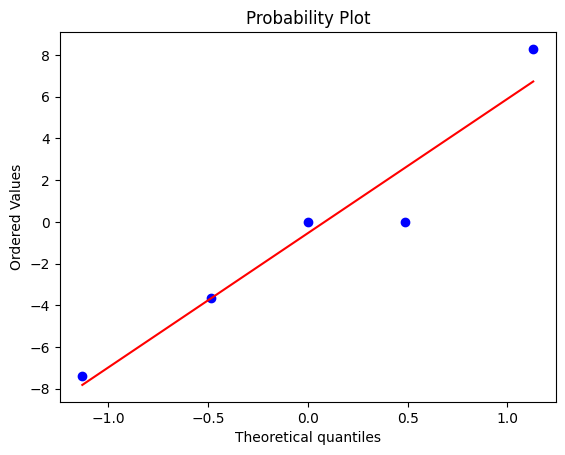

In [24]:
import incawrapper.visualization as incaviz
incaviz.plot_norm_prob(res)

## References
[1] M. R. Antoniewicz, J. K. Kelleher, and G. Stephanopoulos, “Determination of confidence intervals of metabolic fluxes estimated from stable isotope measurements,” Metabolic Engineering, vol. 8, no. 4, pp. 324–337, Jul. 2006, doi: 10.1016/j.ymben.2006.01.004.

[2] M. R. Antoniewicz, J. K. Kelleher, and G. Stephanopoulos, “Elementary metabolite units (EMU): A novel framework for modeling isotopic distributions,” Metabolic Engineering, vol. 9, no. 1, pp. 68–86, Jan. 2007, doi: 10.1016/j.ymben.2006.09.001.
